In [1]:
# Extra Setup for Colaboratory Environment

#!pip install cmake
#!pip install dlib

#from google.colab import files
#uploaded = files.upload() 

#!7za e colaboratory_dependencies.7z
#!7za x frontalization_models.7z
#!7za x dlib_models.7z

In [2]:
'''
Libraries, etc.
'''
import os
import sys
import cv2
import numpy as np 
import scipy as sp
import pandas as pd 
import seaborn as sns
from math import sqrt
import scipy.io as io
import tensorflow as tf 
from pathlib import Path
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.utils import np_utils as npu
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Convolution2D, Activation, BatchNormalization, GaussianNoise, MaxPooling2D, Dropout, Dense, Flatten

import frontalize
import check_resources as check
import camera_calibration as calib
import facial_feature_detector as feature_detection

from models import get_model1, get_model2, get_model3

#this_path = os.path.dirname(os.path.abspath(__file__)) 
this_path = str(Path().resolve()) # for Colaboratory

Using TensorFlow backend.


In [3]:
'''
Constants, Hyperparameters, etc.
'''
BATCH_SIZE = 128
NUM_EPOCHS = 85
input_file = 'fer2013.csv'
filepath = 'Model.{epoch:02d}-{val_acc:.4f}.hdf5'

model1_acc_file = "acc_model1_t2.png"
model2_acc_file = "acc_model2_t2.png"
model3_acc_file = "acc_model3_t2.png"
model4_acc_file = "acc_model4_t2.png"
acc_file = model1_acc_file

model1_loss_file = "loss_model1_t2.png"
model2_loss_file = "loss_model2_t2.png"
model3_loss_file = "loss_model3_t2.png"
model4_loss_file = "loss_model4_t2.png"
loss_file = model1_loss_file

model1_cm_file = "cm_model1_t2.png"
model2_cm_file = "cm_model2_t2.png"
model3_cm_file = "cm_model3_t2.png"
model4_cm_file = "cm_model4_t2.png"
cm_file = model1_cm_file

emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

In [4]:
'''
Load & Parse Data into Training/Test Labels & Images
'''
data = pd.read_csv(input_file)
data.head()

# get data and labels
train_set = data[(data.Usage == 'Training')]
validation_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')]

# greyscale so depth 1
depth = 1
height = int(sqrt(len(data.pixels[0].split())))
width = height

# from pandas to np array
X_train = np.array(list(map(str.split, train_set.pixels)), np.uint8)
X_validation = np.array(list(map(str.split, validation_set.pixels)), np.uint8)
X_test = np.array(list(map(str.split, test_set.pixels)), np.uint8)

# reshape data
num_train = X_train.shape[0]
num_validation = X_validation.shape[0]
num_test = X_test.shape[0]

X_train = X_train.reshape(num_train, width, height, depth)
X_validation = X_validation.reshape(num_validation, width, height, depth)
X_test = X_test.reshape(num_test, width, height, depth)

y_train = train_set.emotion
y_validation = validation_set.emotion
y_test = test_set.emotion

y_train = np_utils.to_categorical(y_train, num_classes)
y_validation = np_utils.to_categorical(y_validation, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# print shapes
print('X_training: ', X_train.shape)
print('X_validation: ', X_validation.shape)
print('X_test: ', X_test.shape)
print( )
print('y_training: ', y_train.shape)
print('y_validation: ', y_validation.shape)
print('y_test: ', y_test.shape)

X_training:  (28709, 48, 48, 1)
X_validation:  (3589, 48, 48, 1)
X_test:  (3589, 48, 48, 1)

y_training:  (28709, 7)
y_validation:  (3589, 7)
y_test:  (3589, 7)


In [5]:
'''
Frontalization Function
'''
def myfrontalize(X, limit=0):
  count = 0

  if (limit == 0):
    limit = X.shape[0]
    
  print("Total Images: ", limit)
    
  # check for dlib saved weights for face landmark detection
  # if it fails, dowload and extract it manually from
  # http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2
  check.check_dlib_landmark_weights()
    
  # load detections performed by dlib library on 3D model and Reference Image
  model3D = frontalize.ThreeD_Model(this_path + "/frontalization_models/model3Ddlib.mat", 'model_dlib')
  
  # load mask to exclude eyes from symmetry
  eyemask = np.asarray(io.loadmat('frontalization_models/eyemask.mat')['eyemask'])
        
  for i in range(0, limit):
    print("\r", end='')
    print("Images Completed: {0}".format(i), end='', flush=True)

    # cast img to type int for cv2
    img = X[i, :, :, 0].astype(np.uint8)
    
    # create a color version for frontalizer stuffs
    c_img = np.copy(img)
    c_img = cv2.cvtColor(c_img, cv2.COLOR_GRAY2BGR)    
    
    # extract landmarks from the query image
    # list containing a 2D array with points (x, y) for each face detected in the query image
    lmarks = feature_detection.get_landmarks(c_img)
    if type(lmarks) is np.ndarray:
      
      # perform camera calibration according to the first face detected
      proj_matrix, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, lmarks[0])
      
      # perform frontalization and convert result to grayscale
      frontal_raw, frontal_sym = frontalize.frontalize(c_img, proj_matrix, model3D.ref_U, eyemask)
      temp = cv2.cvtColor(frontal_raw, cv2.COLOR_BGR2GRAY)
    
      # find nonzero bbox and crop image to remove uncessesary black space from edges           
      temp_mask = cv2.findNonZero(temp)     
      t_x, t_y, t_w, t_h = cv2.boundingRect(temp_mask)
      t_bbox = temp[t_y:t_y+t_h, t_x:t_x+t_w]

      # resize the cropped image to the appropriate dimensions for network
      t_bbox = cv2.resize(t_bbox, dsize=(48, 48))  
      t_bbox = np.resize(t_bbox, (48, 48, 1))   
      X[i] = t_bbox.astype(np.float32)
    
      plt.show()
      count += 1
      
  print( )
  print('{} images out of {} were frontalized.'.format(count, limit))

Original Images


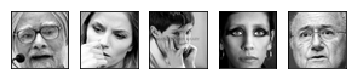

Original w/ Linear Transform to normalize pixel values


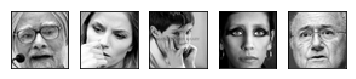

Normalized w/ Contrast Limited Adaptive Histogram Equalization


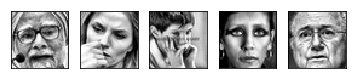

Frontalized, Cropped, and Resized


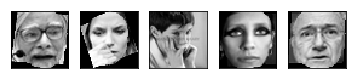

In [6]:
'''
Histogram Equalization - Not defined as method, because 
train has a special case to catch and delete harmful inputs
'''
clahe = cv2.createCLAHE(clipLimit=3.235, tileGridSize=(5,5))

# original image set
X_train1 = X_train.copy().astype(np.uint8)
X_val1 = X_validation.copy().astype(np.uint8)
X_test1 = X_test.copy().astype(np.uint8)

# linear histogram equalization set
X_train2 = X_train1.copy() 
X_val2 = X_val1.copy()
X_test2 = X_test1.copy()

# clahe set
X_train3 = X_train1.copy()
X_val3 = X_val1.copy()
X_test3 = X_test1.copy()

# frontalized set
X_train4 = X_train1.copy()
X_val4 = X_val1.copy()
X_test4 = X_test1.copy()

# histogram equalization
i = 0
while (i < num_train):
  tMax = X_train1[i].max()
  tMin = X_train1[i].min()  

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_train2[i] = np.multiply((X_train1[i] - tMin), tRatio)
    X_train3[i] = clahe.apply(X_train2[i])[:,:,np.newaxis]
    i += 1
    
  # Delete harmful training examples from X_train
  else:
    X_train1 = np.delete(X_train1, (i), axis=0)
    X_train2 = np.delete(X_train2, (i), axis=0)
    X_train3 = np.delete(X_train3, (i), axis=0)
    X_train4 = np.delete(X_train4, (i), axis=0)
    y_train = np.delete(y_train, (i), axis=0)
    num_train -= 1
  
i = 0
while (i < num_validation):
  tMax = X_val1[i].max()
  tMin = X_val1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_val2[i] = np.multiply((X_val1[i] - tMin), tRatio).round()
    
  # Shouldn't delete validation data... skip so we don't divide by 0
  else:
    X_val2[i] = X_val1[i]

  X_val3[i] = clahe.apply(X_val2[i])[:,:,np.newaxis]
  i += 1

i = 0
while (i < num_test):
  tMax = X_test1[i].max()
  tMin = X_test1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_test2[i] = np.multiply((X_test1[i] - tMin), tRatio).round()
    
  # Shouldn't delete test data... skip so we don't divide by 0
  else:
    X_test2[i] = X_test1[i]
    
  X_test3[i] = clahe.apply(X_test2[i])[:,:,np.newaxis]
  i += 1
  
# apply frontalization
#print("Attempting to frontalize image data...")
#myfrontalize(X_train4, num_train)
#np.save('X_train_frontalized', X_train4)

#myfrontalize(X_val4, num_validation)
#np.save('X_val_frontalized', X_val4)

#myfrontalize(X_test4, num_test)
#np.save('X_test_frontalized', X_test4)

X_train4 = np.load('X_train_frontalized.npy')
X_val4 = np.load('X_val_frontalized.npy')
X_test4 = np.load('X_test_frontalized.npy')


# print examples from each set
print('Original Images')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train1[x,:,:,0], cmap='gray') 
plt.show()

print('Original w/ Linear Transform to normalize pixel values')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train2[x,:,:,0], cmap='gray')   
plt.show()

print('Normalized w/ Contrast Limited Adaptive Histogram Equalization')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train3[x,:,:,0], cmap='gray')    
plt.show() 

print('Frontalized, Cropped, and Resized')
for x in range(1,6):
  plt.subplot(1, 5, x)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_train4[x, :, :, 0], cmap='gray') 
    
plt.show()

In [7]:
'''
TensorFlow Model(s)
'''

# shallow model
def get_model1():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# actual model
def get_model2():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (5, 5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# deeper model
def get_model3():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(Convolution2D(64, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(Convolution2D(128, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(Convolution2D(265, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(Convolution2D(512, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(2048))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# shallow model
def get_model4():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (5, 5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

In [8]:
'''
Metric(s)
'''

# metric to balance precision and recall
def fbeta(y_true, y_pred, threshold_shift=0):
  beta = 1

  # just in case of hipster activation at the final layer
  y_pred = K.clip(y_pred, 0, 1)

  # shifting the prediction threshold from .5 if needed
  y_pred_bin = K.round(y_pred + threshold_shift)

  tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
  fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
  fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  beta_squared = beta ** 2
  return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))


In [10]:
'''
Prepare Model for Training
'''
# assign the desired model from above
model1 = get_model1()
model2 = get_model2()
model3 = get_model3()
model4 = get_model4()

#model.summary()

num_train = len(X_train)

# assign X to the desired image set(s) from above
X_train = X_train4.copy()
X_validation = X_val4.copy()
X_test = X_test4.copy()

# reshape X to expected shape and cast it back to type float32
X_train = X_train.reshape(num_train,width,height,1).astype(np.float32)
X_validation = X_validation.reshape(num_validation,width,height,1).astype(np.float32)
X_test = X_test.reshape(num_test,width,height,1).astype(np.float32)

# augment and fit data
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=False)
datagen.fit(X_train)
datagen.fit(X_validation)

# to be applied during training
checkpointer = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, 
    save_best_only=False, mode='auto')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, 
    patience=10, verbose=0, mode='auto', 
    min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, 
    verbose=0, mode='auto')

# prepare model to train
model1.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model2.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model3.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model4.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

In [11]:
'''
Training
'''
train_flow = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_flow = datagen.flow(X_validation, y_validation)

history1 = model1.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history2 = model2.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history3 = model3.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history4 = model4.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

Epoch 1/85
225/224 [==============================] - 12s 51ms/step - loss: 1.7872 - fbeta: 0.1061 - acc: 0.3086 - val_loss: 1.5897 - val_fbeta: 0.2155 - val_acc: 0.3685

Epoch 00001: saving model to Model.01-0.3685.hdf5

Epoch 00001: saving model to Model.01-0.3685.hdf5
Epoch 2/85
225/224 [==============================] - 7s 33ms/step - loss: 1.4728 - fbeta: 0.2189 - acc: 0.4318 - val_loss: 1.3955 - val_fbeta: 0.3017 - val_acc: 0.4634

Epoch 00002: saving model to Model.02-0.4634.hdf5

Epoch 00002: saving model to Model.02-0.4634.hdf5
Epoch 3/85
225/224 [==============================] - 7s 33ms/step - loss: 1.3345 - fbeta: 0.2793 - acc: 0.4883 - val_loss: 1.3311 - val_fbeta: 0.2823 - val_acc: 0.4989

Epoch 00003: saving model to Model.03-0.4989.hdf5

Epoch 00003: saving model to Model.03-0.4989.hdf5
Epoch 4/85
225/224 [==============================] - 7s 33ms/step - loss: 1.2458 - fbeta: 0.3205 - acc: 0.5223 - val_loss: 1.2432 - val_fbeta: 0.3219 - val_acc: 0.5172

Epoch 00004: sav

225/224 [==============================] - 7s 33ms/step - loss: 0.6013 - fbeta: 0.7103 - acc: 0.7759 - val_loss: 1.1026 - val_fbeta: 0.5905 - val_acc: 0.6422

Epoch 00031: saving model to Model.31-0.6422.hdf5

Epoch 00031: saving model to Model.31-0.6422.hdf5
Epoch 32/85
225/224 [==============================] - 7s 33ms/step - loss: 0.5890 - fbeta: 0.7161 - acc: 0.7817 - val_loss: 1.0074 - val_fbeta: 0.6016 - val_acc: 0.6570

Epoch 00032: saving model to Model.32-0.6570.hdf5

Epoch 00032: saving model to Model.32-0.6570.hdf5
Epoch 33/85
225/224 [==============================] - 7s 33ms/step - loss: 0.5817 - fbeta: 0.7203 - acc: 0.7823 - val_loss: 0.9733 - val_fbeta: 0.6142 - val_acc: 0.6649s - los - ETA: 2s - loss:

Epoch 00033: saving model to Model.33-0.6649.hdf5

Epoch 00033: saving model to Model.33-0.6649.hdf5
Epoch 34/85
225/224 [==============================] - 8s 33ms/step - loss: 0.5717 - fbeta: 0.7282 - acc: 0.7889 - val_loss: 1.0926 - val_fbeta: 0.5905 - val_acc: 0.6422



225/224 [==============================] - 7s 33ms/step - loss: 0.4957 - fbeta: 0.7714 - acc: 0.8165 - val_loss: 1.1428 - val_fbeta: 0.6056 - val_acc: 0.6444

Epoch 00061: saving model to Model.61-0.6444.hdf5

Epoch 00061: saving model to Model.61-0.6444.hdf5
Epoch 62/85
225/224 [==============================] - 7s 33ms/step - loss: 0.4970 - fbeta: 0.7682 - acc: 0.8163 - val_loss: 1.0256 - val_fbeta: 0.6207 - val_acc: 0.6616

Epoch 00062: saving model to Model.62-0.6616.hdf5

Epoch 00062: saving model to Model.62-0.6616.hdf5
Epoch 63/85
225/224 [==============================] - 7s 33ms/step - loss: 0.4932 - fbeta: 0.7704 - acc: 0.8161 - val_loss: 0.9881 - val_fbeta: 0.6326 - val_acc: 0.6915

Epoch 00063: saving model to Model.63-0.6915.hdf5

Epoch 00063: saving model to Model.63-0.6915.hdf5
Epoch 64/85
225/224 [==============================] - 7s 33ms/step - loss: 0.4922 - fbeta: 0.7706 - acc: 0.8182 - val_loss: 1.0735 - val_fbeta: 0.5851 - val_acc: 0.6293

Epoch 00064: saving model

225/224 [==============================] - 9s 40ms/step - loss: 1.1540 - fbeta: 0.3758 - acc: 0.5617 - val_loss: 1.2661 - val_fbeta: 0.4116 - val_acc: 0.5366

Epoch 00006: saving model to Model.06-0.5366.hdf5

Epoch 00006: saving model to Model.06-0.5366.hdf5
Epoch 7/85
225/224 [==============================] - 9s 40ms/step - loss: 1.1219 - fbeta: 0.3966 - acc: 0.5741 - val_loss: 1.1581 - val_fbeta: 0.3718 - val_acc: 0.5485

Epoch 00007: saving model to Model.07-0.5485.hdf5

Epoch 00007: saving model to Model.07-0.5485.hdf5
Epoch 8/85
225/224 [==============================] - 9s 41ms/step - loss: 1.0855 - fbeta: 0.4205 - acc: 0.5860 - val_loss: 1.1572 - val_fbeta: 0.3873 - val_acc: 0.5705

Epoch 00008: saving model to Model.08-0.5705.hdf5

Epoch 00008: saving model to Model.08-0.5705.hdf5
Epoch 9/85
225/224 [==============================] - 9s 40ms/step - loss: 1.0541 - fbeta: 0.4408 - acc: 0.5994 - val_loss: 1.0915 - val_fbeta: 0.4300 - val_acc: 0.5916

Epoch 00009: saving model to

225/224 [==============================] - 9s 41ms/step - loss: 0.4682 - fbeta: 0.7847 - acc: 0.8266 - val_loss: 1.1608 - val_fbeta: 0.5971 - val_acc: 0.6459

Epoch 00036: saving model to Model.36-0.6459.hdf5

Epoch 00036: saving model to Model.36-0.6459.hdf5
Epoch 37/85
225/224 [==============================] - 9s 40ms/step - loss: 0.4612 - fbeta: 0.7898 - acc: 0.8298 - val_loss: 1.0121 - val_fbeta: 0.6390 - val_acc: 0.6746

Epoch 00037: saving model to Model.37-0.6746.hdf5

Epoch 00037: saving model to Model.37-0.6746.hdf5
Epoch 38/85
225/224 [==============================] - 9s 40ms/step - loss: 0.4556 - fbeta: 0.7960 - acc: 0.8334 - val_loss: 1.0992 - val_fbeta: 0.6121 - val_acc: 0.6606

Epoch 00038: saving model to Model.38-0.6606.hdf5

Epoch 00038: saving model to Model.38-0.6606.hdf5
Epoch 39/85
225/224 [==============================] - 9s 41ms/step - loss: 0.4552 - fbeta: 0.7930 - acc: 0.8300 - val_loss: 1.1622 - val_fbeta: 0.6249 - val_acc: 0.6637

Epoch 00039: saving model

225/224 [==============================] - 9s 40ms/step - loss: 0.3975 - fbeta: 0.8230 - acc: 0.8542 - val_loss: 1.1609 - val_fbeta: 0.6228 - val_acc: 0.6573

Epoch 00066: saving model to Model.66-0.6573.hdf5

Epoch 00066: saving model to Model.66-0.6573.hdf5
Epoch 67/85
225/224 [==============================] - 9s 41ms/step - loss: 0.3960 - fbeta: 0.8253 - acc: 0.8550 - val_loss: 1.2347 - val_fbeta: 0.6149 - val_acc: 0.6504

Epoch 00067: saving model to Model.67-0.6504.hdf5

Epoch 00067: saving model to Model.67-0.6504.hdf5
Epoch 68/85
225/224 [==============================] - 9s 40ms/step - loss: 0.3954 - fbeta: 0.8269 - acc: 0.8561 - val_loss: 1.1013 - val_fbeta: 0.6509 - val_acc: 0.6843

Epoch 00068: saving model to Model.68-0.6843.hdf5

Epoch 00068: saving model to Model.68-0.6843.hdf5
Epoch 69/85
225/224 [==============================] - 9s 40ms/step - loss: 0.4018 - fbeta: 0.8234 - acc: 0.8539 - val_loss: 1.1889 - val_fbeta: 0.6131 - val_acc: 0.6412

Epoch 00069: saving model

225/224 [==============================] - 14s 61ms/step - loss: 1.0998 - fbeta: 0.4107 - acc: 0.5826 - val_loss: 1.1074 - val_fbeta: 0.4149 - val_acc: 0.5981

Epoch 00011: saving model to Model.11-0.5981.hdf5

Epoch 00011: saving model to Model.11-0.5981.hdf5
Epoch 12/85
225/224 [==============================] - 14s 61ms/step - loss: 1.0919 - fbeta: 0.4159 - acc: 0.5844 - val_loss: 1.0842 - val_fbeta: 0.4129 - val_acc: 0.5782

Epoch 00012: saving model to Model.12-0.5782.hdf5

Epoch 00012: saving model to Model.12-0.5782.hdf5
Epoch 13/85
225/224 [==============================] - 14s 61ms/step - loss: 1.0705 - fbeta: 0.4280 - acc: 0.5915 - val_loss: 1.1525 - val_fbeta: 0.4116 - val_acc: 0.5722

Epoch 00013: saving model to Model.13-0.5722.hdf5

Epoch 00013: saving model to Model.13-0.5722.hdf5
Epoch 14/85
225/224 [==============================] - 14s 61ms/step - loss: 1.0635 - fbeta: 0.4367 - acc: 0.5981 - val_loss: 1.1037 - val_fbeta: 0.4666 - val_acc: 0.5894

Epoch 00014: saving m

225/224 [==============================] - 14s 60ms/step - loss: 0.7909 - fbeta: 0.6039 - acc: 0.7001 - val_loss: 1.0517 - val_fbeta: 0.5474 - val_acc: 0.6261

Epoch 00041: saving model to Model.41-0.6261.hdf5

Epoch 00041: saving model to Model.41-0.6261.hdf5
Epoch 42/85
225/224 [==============================] - 14s 60ms/step - loss: 0.7401 - fbeta: 0.6205 - acc: 0.7195 - val_loss: 0.9635 - val_fbeta: 0.5625 - val_acc: 0.6519 0.7400 - fbeta: 0.6207 - acc: 0.7

Epoch 00042: saving model to Model.42-0.6519.hdf5

Epoch 00042: saving model to Model.42-0.6519.hdf5
Epoch 43/85
225/224 [==============================] - 14s 61ms/step - loss: 0.7122 - fbeta: 0.6378 - acc: 0.7299 - val_loss: 0.8678 - val_fbeta: 0.6027 - val_acc: 0.6848

Epoch 00043: saving model to Model.43-0.6848.hdf5

Epoch 00043: saving model to Model.43-0.6848.hdf5
Epoch 44/85
225/224 [==============================] - 14s 61ms/step - loss: 0.7048 - fbeta: 0.6401 - acc: 0.7306 - val_loss: 1.0339 - val_fbeta: 0.5647 - val_

Epoch 71/85
225/224 [==============================] - 14s 61ms/step - loss: 0.6378 - fbeta: 0.6845 - acc: 0.7603 - val_loss: 0.9679 - val_fbeta: 0.6060 - val_acc: 0.6637

Epoch 00071: saving model to Model.71-0.6637.hdf5

Epoch 00071: saving model to Model.71-0.6637.hdf5
Epoch 72/85
225/224 [==============================] - 14s 61ms/step - loss: 0.6411 - fbeta: 0.6864 - acc: 0.7590 - val_loss: 0.9570 - val_fbeta: 0.6293 - val_acc: 0.6800

Epoch 00072: saving model to Model.72-0.6800.hdf5

Epoch 00072: saving model to Model.72-0.6800.hdf5
Epoch 73/85
225/224 [==============================] - 14s 61ms/step - loss: 0.6449 - fbeta: 0.6835 - acc: 0.7584 - val_loss: 1.0031 - val_fbeta: 0.5841 - val_acc: 0.6498

Epoch 00073: saving model to Model.73-0.6498.hdf5

Epoch 00073: saving model to Model.73-0.6498.hdf5
Epoch 74/85
225/224 [==============================] - 14s 61ms/step - loss: 0.6393 - fbeta: 0.6846 - acc: 0.7584 - val_loss: 1.0173 - val_fbeta: 0.5981 - val_acc: 0.6681

Epoch 000

225/224 [==============================] - 6s 26ms/step - loss: 0.7264 - fbeta: 0.6400 - acc: 0.7376 - val_loss: 1.2204 - val_fbeta: 0.4440 - val_acc: 0.5494

Epoch 00016: saving model to Model.16-0.5494.hdf5

Epoch 00016: saving model to Model.16-0.5494.hdf5
Epoch 17/85
225/224 [==============================] - 6s 25ms/step - loss: 0.6956 - fbeta: 0.6555 - acc: 0.7475 - val_loss: 1.2552 - val_fbeta: 0.4440 - val_acc: 0.5647

Epoch 00017: saving model to Model.17-0.5647.hdf5

Epoch 00017: saving model to Model.17-0.5647.hdf5
Epoch 18/85
225/224 [==============================] - 6s 25ms/step - loss: 0.6467 - fbeta: 0.6840 - acc: 0.7695 - val_loss: 1.3954 - val_fbeta: 0.4418 - val_acc: 0.5420

Epoch 00018: saving model to Model.18-0.5420.hdf5

Epoch 00018: saving model to Model.18-0.5420.hdf5
Epoch 19/85
225/224 [==============================] - 6s 25ms/step - loss: 0.5593 - fbeta: 0.7290 - acc: 0.8068 - val_loss: 1.1553 - val_fbeta: 0.5172 - val_acc: 0.6002

Epoch 00019: saving model

225/224 [==============================] - 6s 25ms/step - loss: 0.3259 - fbeta: 0.8536 - acc: 0.8911 - val_loss: 1.2377 - val_fbeta: 0.5409 - val_acc: 0.5916

Epoch 00046: saving model to Model.46-0.5916.hdf5

Epoch 00046: saving model to Model.46-0.5916.hdf5
Epoch 47/85
225/224 [==============================] - 6s 25ms/step - loss: 0.3271 - fbeta: 0.8530 - acc: 0.8911 - val_loss: 1.2822 - val_fbeta: 0.5438 - val_acc: 0.5916

Epoch 00047: saving model to Model.47-0.5916.hdf5

Epoch 00047: saving model to Model.47-0.5916.hdf5
Epoch 48/85
225/224 [==============================] - 6s 25ms/step - loss: 0.3244 - fbeta: 0.8537 - acc: 0.8920 - val_loss: 1.2976 - val_fbeta: 0.5571 - val_acc: 0.5991

Epoch 00048: saving model to Model.48-0.5991.hdf5

Epoch 00048: saving model to Model.48-0.5991.hdf5
Epoch 49/85
225/224 [==============================] - 6s 25ms/step - loss: 0.3291 - fbeta: 0.8531 - acc: 0.8901 - val_loss: 1.2571 - val_fbeta: 0.5528 - val_acc: 0.6078

Epoch 00049: saving model

225/224 [==============================] - 6s 25ms/step - loss: 0.3233 - fbeta: 0.8534 - acc: 0.8911 - val_loss: 1.2572 - val_fbeta: 0.5614 - val_acc: 0.6131

Epoch 00076: saving model to Model.76-0.6131.hdf5

Epoch 00076: saving model to Model.76-0.6131.hdf5
Epoch 77/85
225/224 [==============================] - 6s 25ms/step - loss: 0.3261 - fbeta: 0.8545 - acc: 0.8922 - val_loss: 1.2041 - val_fbeta: 0.5528 - val_acc: 0.6131

Epoch 00077: saving model to Model.77-0.6131.hdf5

Epoch 00077: saving model to Model.77-0.6131.hdf5
Epoch 78/85
225/224 [==============================] - 6s 26ms/step - loss: 0.3301 - fbeta: 0.8506 - acc: 0.8892 - val_loss: 1.2470 - val_fbeta: 0.5760 - val_acc: 0.6293

Epoch 00078: saving model to Model.78-0.6293.hdf5

Epoch 00078: saving model to Model.78-0.6293.hdf5
Epoch 79/85
225/224 [==============================] - 6s 25ms/step - loss: 0.3242 - fbeta: 0.8554 - acc: 0.8923 - val_loss: 1.1978 - val_fbeta: 0.5614 - val_acc: 0.6175

Epoch 00079: saving model

In [12]:
'''
Evaluate Test Set & Print Results
'''
score = model1.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 1 Evaluation Loss: ', score[0])
print('Model 1 Evaluation Accuracy: ', score[1])

score = model2.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 2 Evaluation Loss: ', score[0])
print('Model 2 Evaluation Accuracy: ', score[1])

score = model3.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 3 Evaluation Loss: ', score[0])
print('Model 3 Evaluation Accuracy: ', score[1])

score = model4.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 4 Evaluation Loss: ', score[0])
print('Model 4 Evaluation Accuracy: ', score[1])

28/28 [==============================] - 6s 230ms/step
Model 1 Evaluation Loss:  1.0063122510910034
Model 1 Evaluation Accuracy:  0.6263583302497864
28/28 [==============================] - 8s 294ms/step
Model 2 Evaluation Loss:  1.0930755138397217
Model 2 Evaluation Accuracy:  0.6383393406867981
28/28 [==============================] - 12s 444ms/step
Model 3 Evaluation Loss:  0.9463574886322021
Model 3 Evaluation Accuracy:  0.6193925738334656
28/28 [==============================] - 4s 147ms/step
Model 4 Evaluation Loss:  1.187814712524414
Model 4 Evaluation Accuracy:  0.5720256567001343


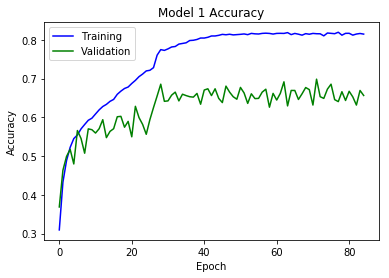

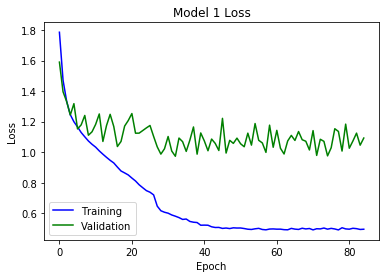

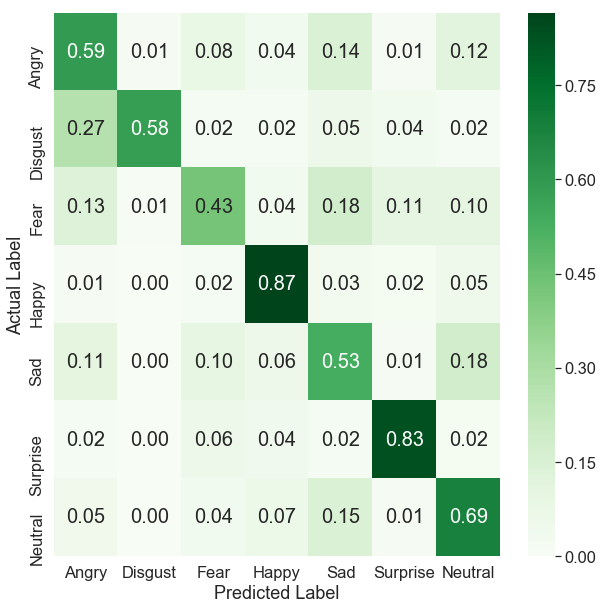

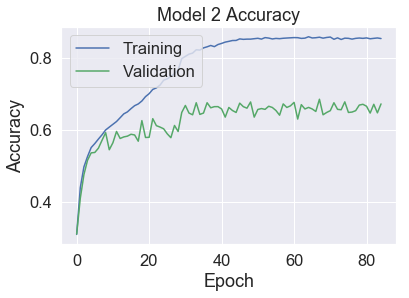

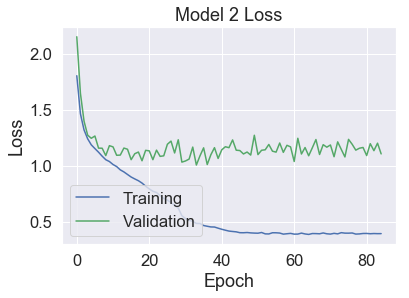

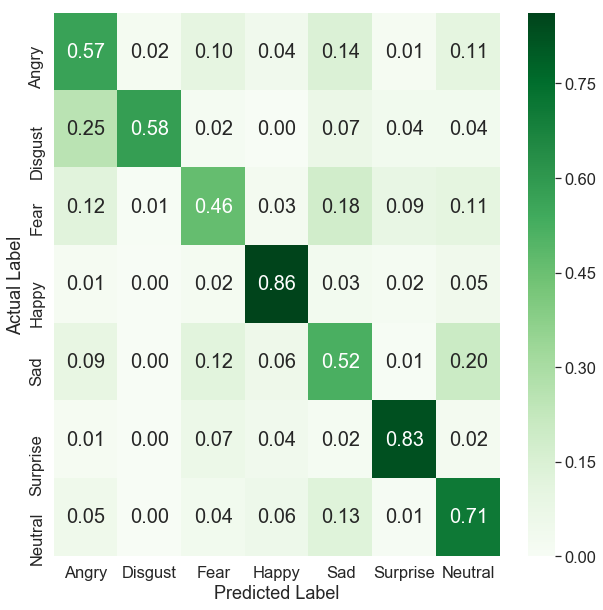

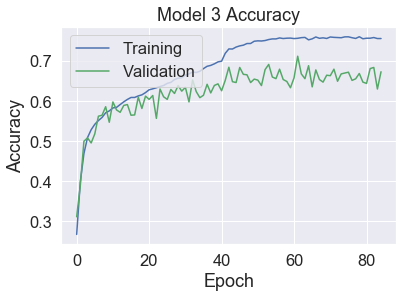

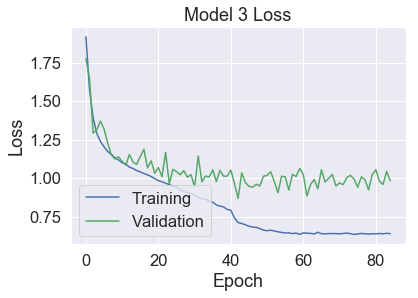

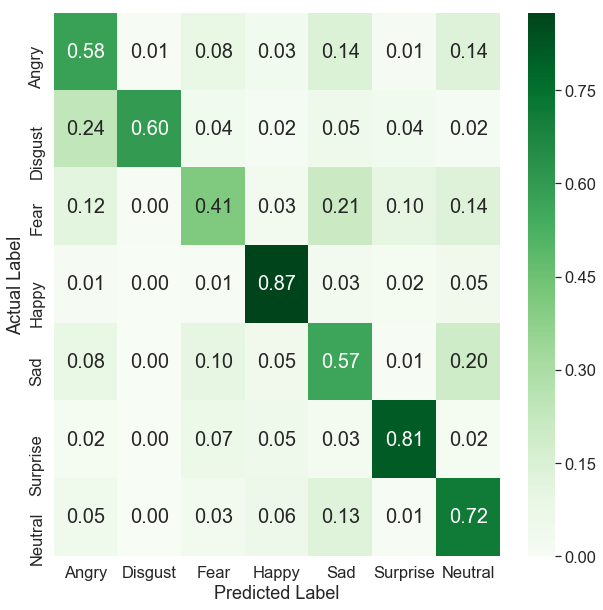

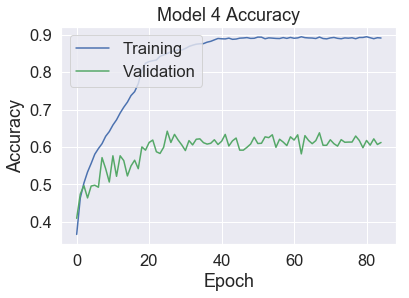

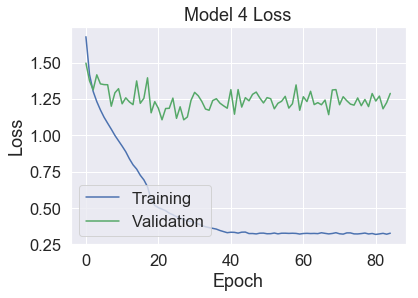

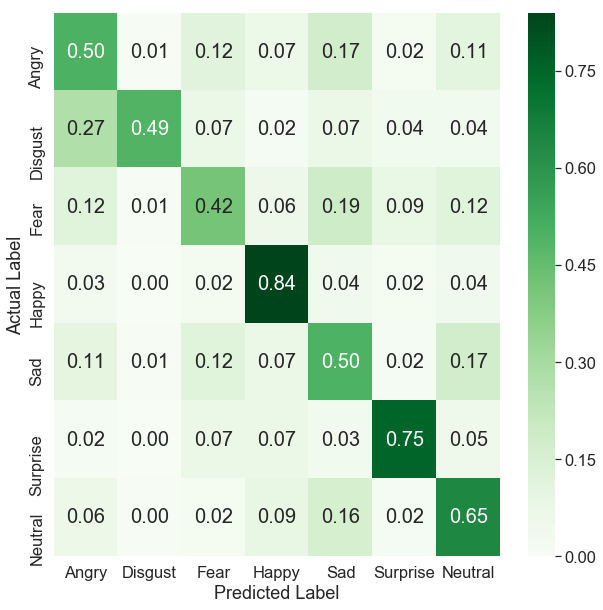

In [13]:
# Model 1 Stats
plt.figure()
plt.plot(history1.history['acc'], color='b', label='Training')
plt.plot(history1.history['val_acc'], color='g', label='Validation')
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history1.history['loss'], color='b', label='Training')
plt.plot(history1.history['val_loss'], color='g', label='Validation')
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model1.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()


# Model 2 Stats
plt.figure()
plt.plot(history2.history['acc'], color='b', label='Training')
plt.plot(history2.history['val_acc'], color='g', label='Validation')
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history2.history['loss'], color='b', label='Training')
plt.plot(history2.history['val_loss'], color='g', label='Validation')
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model2.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()


# Model 3 Stats
plt.figure()
plt.plot(history3.history['acc'], color='b', label='Training')
plt.plot(history3.history['val_acc'], color='g', label='Validation')
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history3.history['loss'], color='b', label='Training')
plt.plot(history3.history['val_loss'], color='g', label='Validation')
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model3.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()


# Model 4 Stats
plt.figure()
plt.plot(history4.history['acc'], color='b', label='Training')
plt.plot(history4.history['val_acc'], color='g', label='Validation')
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history4.history['loss'], color='b', label='Training')
plt.plot(history4.history['val_loss'], color='g', label='Validation')
plt.title('Model 4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model4.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()

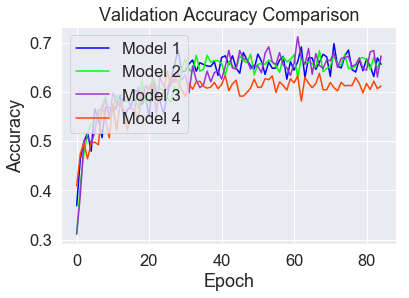

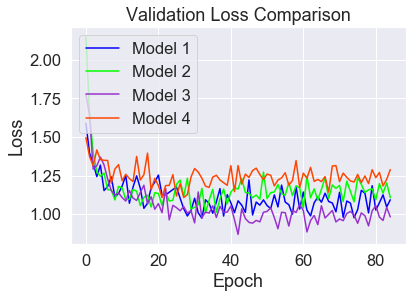

In [14]:
# Validation Comparison
fig1 = plt.figure()
plt.plot(history1.history['val_acc'], color='#0000FF', label='Model 1')
plt.plot(history2.history['val_acc'], color='#00FF00', label='Model 2')
plt.plot(history3.history['val_acc'], color='#9932CC', label='Model 3')
plt.plot(history4.history['val_acc'], color='#FF4500', label='Model 4')
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig(acc_file)
plt.show() 

# Loss Comparison
fig1 = plt.figure()
plt.plot(history1.history['val_loss'], color='#0000FF', label='Model 1')
plt.plot(history2.history['val_loss'], color='#00FF00', label='Model 2')
plt.plot(history3.history['val_loss'], color='#9932CC', label='Model 3')
plt.plot(history4.history['val_loss'], color='#FF4500', label='Model 4')
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig(acc_file)
plt.show() 